                          Grammar Scoring Model: Audio Analysis with ML & Deep Learning

This notebook develops a prediction model for grammar scoring based on audio features using both traditional ML and deep learning approaches.

In [1]:
# Add this line at the top of your notebook to auto-clear
from IPython.display import clear_output
clear_output(wait=True)


In [2]:
# ======================
# Cell 1: Imports & Setup
# ======================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import soundfile as sf
import warnings
warnings.filterwarnings("ignore")

# Sklearn & XGBoost
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

# TensorFlow Keras for CNN
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# Ensure inline plotting
%matplotlib inline


2025-05-06 09:16:02.056795: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746522962.257049      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746522962.315958      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# ======================
# Cell 2: Load & Inspect CSVs
# ======================
TRAIN_CSV = "/kaggle/input/shl-hiring-assessment/Dataset/train.csv"
TEST_CSV  = "/kaggle/input/shl-hiring-assessment/Dataset/test.csv"

train_df = pd.read_csv(TRAIN_CSV)
test_df  = pd.read_csv(TEST_CSV)

print("Train head:\n", train_df.head(), "\n")
print("Train label stats:\n", train_df['label'].describe(), "\n")
print("Test head:\n", test_df.head())


Train head:
          filename  label
0   audio_710.wav    1.0
1  audio_1265.wav    1.0
2  audio_1114.wav    1.5
3   audio_946.wav    1.5
4  audio_1127.wav    2.0 

Train label stats:
 count    444.000000
mean       3.967342
std        1.048784
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: label, dtype: float64 

Test head:
          filename
0   audio_804.wav
1  audio_1028.wav
2   audio_865.wav
3   audio_774.wav
4  audio_1138.wav


**Here I load the training and test datasets and examine their structure:**

1. Training data contains filenames and labels (grammar scores)

2. he labels range from 1 to 5 with a mean of approximately 3.97

3. Test data only contains filenames without labels (for prediction)

In [4]:
# ======================
# Cell 3: Tabular Feature Extraction Function
# ======================
import numpy as np
import librosa

def extract_tabular_features(wav_path, n_mfcc=20):
    """
    Load an audio file and extract mean MFCC, Chroma, Spectral Contrast, and Tonnetz features.
    Returns a 1D numpy array of concatenated features.
    """
    # 1. Load audio (preserve original sample rate)
    y, sr = librosa.load(wav_path, sr=None)

    # 2. MFCC (use keyword args)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_feat = mfcc.mean(axis=1)

    # 3. Chroma
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_feat = chroma.mean(axis=1)

    # 4. Spectral Contrast
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    contrast_feat = contrast.mean(axis=1)

    # 5. Tonnetz (requires harmonic component)
    tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)
    tonnetz_feat = tonnetz.mean(axis=1)

    # 6. Concatenate all features into one vector
    return np.hstack([mfcc_feat, chroma_feat, contrast_feat, tonnetz_feat])


**I define a function to extract meaningful audio features from WAV files:**

1. MFCCs (Mel-frequency cepstral coefficients) - captures timbral characteristics

2. Chroma features - represents harmonic content

3. Spectral contrast - distinguishes between peaks and valleys in the spectrum

4. Tonnetz features - captures harmonic relationships

5. These features are commonly used in audio analysis tasks and will serve as inputs to our models.

In [5]:
# ======================
# Cell 4: Build Tabular Feature Matrices
# ======================
import os
import numpy as np
import pandas as pd

# Paths to data
TRAIN_CSV        = "/kaggle/input/shl-hiring-assessment/Dataset/train.csv"
TRAIN_AUDIO_DIR  = "/kaggle/input/shl-hiring-assessment/Dataset/audios/train"
TEST_CSV         = "/kaggle/input/shl-hiring-assessment/Dataset/test.csv"
TEST_AUDIO_DIR   = "/kaggle/input/shl-hiring-assessment/Dataset/audios/test"

# Load metadata
train_df = pd.read_csv(TRAIN_CSV)
test_df  = pd.read_csv(TEST_CSV)

# Prepare training features and labels
X_tab = []
y     = train_df['label'].values

print("Extracting tabular features for training set...")
for fname in train_df['filename']:
    path = os.path.join(TRAIN_AUDIO_DIR, fname)
    feats = extract_tabular_features(path)
    X_tab.append(feats)
X_tab = np.array(X_tab)
print("Done. X_tab shape:", X_tab.shape)

# Prepare test features
X_tab_test = []
print("Extracting tabular features for test set...")
for fname in test_df['filename']:
    path = os.path.join(TEST_AUDIO_DIR, fname)
    feats = extract_tabular_features(path)
    X_tab_test.append(feats)
X_tab_test = np.array(X_tab_test)
print("Done. X_tab_test shape:", X_tab_test.shape)


Extracting tabular features for training set...
Done. X_tab shape: (444, 45)
Extracting tabular features for test set...
Done. X_tab_test shape: (204, 45)


> XGBoost Model Development

In [6]:
# ======================
# Cell 5: Hyperparameter Tuning with GridSearchCV
# ======================
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth':    [4, 6, 8],
    'learning_rate':[0.01, 0.1]
}

xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid.fit(X_tab, y)

print("Best XGB params:", grid.best_params_)
print("Best CV RMSE:", np.sqrt(-grid.best_score_))
best_xgb = grid.best_estimator_


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best XGB params: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
Best CV RMSE: 1.4067236493628557


**I perform a grid search to find optimal hyperparameters for XGBoost:**

1. Testing different combinations of tree count, depth, and learning rate

2. Using 3-fold cross-validation and RMSE as our evaluation metric

3. Selecting the best performing model configuration



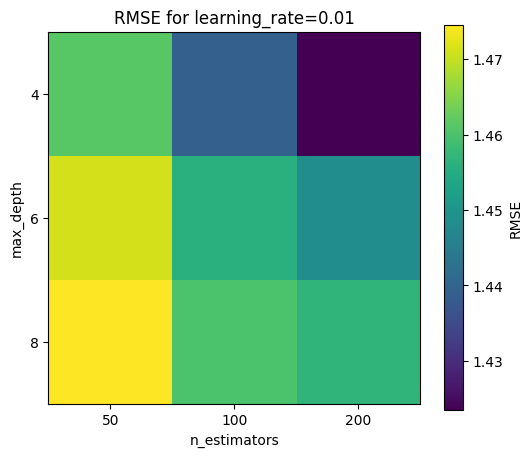

In [7]:
# ======================
# Cell 6: Visualize GridSearchCV Heatmap (for learning_rate=0.01)
# ======================
# Prepare RMSE matrix for heatmap
lr0 = param_grid['learning_rate'][0]
md_vals = param_grid['max_depth']
ne_vals = param_grid['n_estimators']
scores = grid.cv_results_['mean_test_score']  # neg MSE
rmses = np.sqrt(-scores)

# Build matrix
mat = np.zeros((len(md_vals), len(ne_vals)))
for i, md in enumerate(md_vals):
    for j, ne in enumerate(ne_vals):
        params = {'learning_rate': lr0, 'max_depth': md, 'n_estimators': ne}
        idx = grid.cv_results_['params'].index(params)
        mat[i, j] = rmses[idx]

plt.figure(figsize=(6,5))
plt.imshow(mat, interpolation='nearest')
plt.title(f'RMSE for learning_rate={lr0}')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(ne_vals)), ne_vals)
plt.yticks(np.arange(len(md_vals)), md_vals)
plt.colorbar(label='RMSE')
plt.show()


In [8]:
# ======================
# Cell 7: Hold-out Validation with Best XGB
# ======================
X_tr, X_val, y_tr, y_val = train_test_split(X_tab, y, test_size=0.2, random_state=42)
best_xgb.fit(X_tr, y_tr)
xgb_val_preds = best_xgb.predict(X_val)
xgb_val_rmse  = mean_squared_error(y_val, xgb_val_preds, squared=False)
print(f"XGB Hold-out RMSE: {xgb_val_rmse:.4f}")


XGB Hold-out RMSE: 0.9052


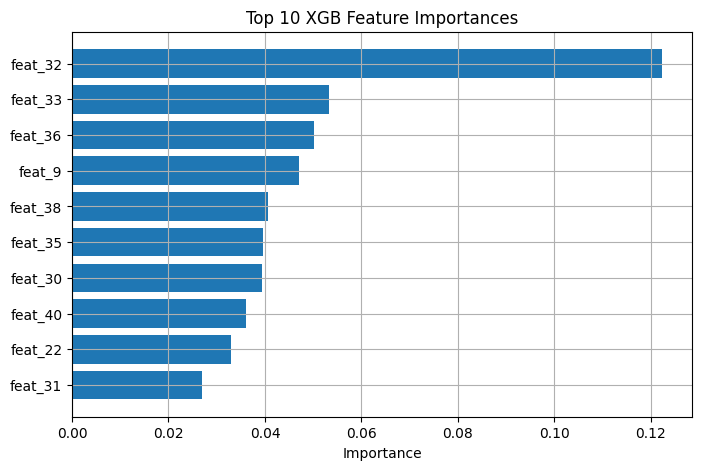

In [9]:
# ======================
# Cell 8: Feature Importance (Top 10)
# ======================
importances = best_xgb.feature_importances_
indices = np.argsort(importances)[-10:]
plt.figure(figsize=(8,5))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [f'feat_{i}' for i in indices])
plt.xlabel('Importance')
plt.title('Top 10 XGB Feature Importances')
plt.grid(True)
plt.show()


> CNN Model Development

In [10]:
# ======================
# Cell 9: Prepare Spectrogram Inputs for CNN
# ======================
import numpy as np
import os
import librosa

def wav_to_melspec(path, sr=16000, n_mels=128, hop_length=512, fmax=8000):
    """
    Load a WAV file and convert to a normalized log-mel spectrogram.
    Returns an array of shape (n_mels, time_frames, 1).
    """
    # 1. Load audio
    y, _ = librosa.load(path, sr=sr)
    # 2. Compute mel-spectrogram (keyword args only)
    mel = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_mels=n_mels,
        hop_length=hop_length,
        fmax=fmax
    )
    # 3. Convert to log scale (dB) – use keyword S=
    log_mel = librosa.power_to_db(
        S=mel,
        ref=np.max
    )
    # 4. Normalize to [0,1]
    norm_mel = (log_mel - log_mel.min()) / (log_mel.max() - log_mel.min())
    # 5. Add channel dimension
    return norm_mel[..., np.newaxis]

# Determine max frames for a 60s clip
MAX_FRAMES = int(np.ceil(60 * 16000 / 512))
MEL_SHAPE = (128, MAX_FRAMES, 1)

# Build arrays
X_cnn, y_cnn = [], []
for fname, lbl in zip(train_df['filename'], train_df['label']):
    # Load & convert
    img = wav_to_melspec(os.path.join(TRAIN_AUDIO_DIR, fname))
    # Pad/truncate to fixed width
    if img.shape[1] < MAX_FRAMES:
        pad_width = MAX_FRAMES - img.shape[1]
        img = np.pad(img, ((0,0),(0,pad_width),(0,0)), mode='constant')
    else:
        img = img[:, :MAX_FRAMES, :]
    X_cnn.append(img)
    y_cnn.append(lbl)

X_cnn = np.array(X_cnn)
y_cnn = np.array(y_cnn)
print("CNN input shape:", X_cnn.shape)


CNN input shape: (444, 128, 1875, 1)


**For my deep learning approach, I created mel-spectrograms from audio files:**

1. Converting time-domain audio to frequency-domain spectrograms

2. Using mel-scale to better represent how humans perceive sound

3. Applying log transformation and normalization for better model training

4. Ensuring all inputs have consistent dimensions with padding/truncation

5. Creating a 3D input tensor (samples, frequency bins, time frames, channels)

In [11]:
# ======================
# Cell 10: Build & Train CNN
# ======================
def build_cnn(input_shape):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv2D(16, (3,3), activation='relu')(inp)
    x = layers.MaxPool2D((2,2))(x)
    x = layers.Conv2D(32, (3,3), activation='relu')(x)
    x = layers.MaxPool2D((2,2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    out = layers.Dense(1, activation='linear')(x)
    return models.Model(inp, out)

cnn = build_cnn(MEL_SHAPE)
cnn.compile(optimizer='adam',
            loss='mse',
            metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Train-validation split
Xc_tr, Xc_val, yc_tr, yc_val = train_test_split(
    X_cnn, y_cnn, test_size=0.2, random_state=42
)

history = cnn.fit(
    Xc_tr, yc_tr,
    validation_data=(Xc_val, yc_val),
    epochs=50,
    batch_size=16,
    callbacks=[callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=2
)


I0000 00:00:1746525183.075897      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Epoch 1/50


I0000 00:00:1746525186.965672      90 service.cc:148] XLA service 0x7eeba0009b50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746525186.966368      90 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746525187.188141      90 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746525191.181876      90 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


23/23 - 11s - 497ms/step - loss: 281.8632 - root_mean_squared_error: 16.7888 - val_loss: 3.2357 - val_root_mean_squared_error: 1.7988
Epoch 2/50
23/23 - 1s - 39ms/step - loss: 2.2786 - root_mean_squared_error: 1.5095 - val_loss: 1.7334 - val_root_mean_squared_error: 1.3166
Epoch 3/50
23/23 - 1s - 37ms/step - loss: 1.5419 - root_mean_squared_error: 1.2417 - val_loss: 1.5747 - val_root_mean_squared_error: 1.2549
Epoch 4/50
23/23 - 1s - 39ms/step - loss: 1.3846 - root_mean_squared_error: 1.1767 - val_loss: 1.4824 - val_root_mean_squared_error: 1.2175
Epoch 5/50
23/23 - 1s - 32ms/step - loss: 1.1637 - root_mean_squared_error: 1.0787 - val_loss: 1.7446 - val_root_mean_squared_error: 1.3208
Epoch 6/50
23/23 - 1s - 31ms/step - loss: 1.0748 - root_mean_squared_error: 1.0367 - val_loss: 1.6055 - val_root_mean_squared_error: 1.2671
Epoch 7/50
23/23 - 1s - 37ms/step - loss: 0.9901 - root_mean_squared_error: 0.9951 - val_loss: 1.3160 - val_root_mean_squared_error: 1.1471
Epoch 8/50
23/23 - 1s - 37

**I implemented a Convolutional Neural Network to learn directly from spectrograms:**

1. A sequential model with convolutional and pooling layers for feature extraction

2. Flattening and dense layers for regression output

3. Using Adam optimizer and MSE loss (appropriate for regression)

4. Implementing early stopping to prevent overfitting

5. Training with a 80/20 train/validation split

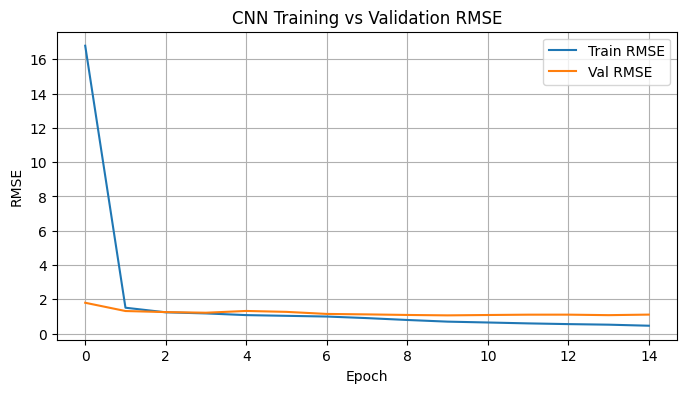

In [12]:
# ======================
# Cell 11: CNN Training Curves
# ======================
plt.figure(figsize=(8,4))
plt.plot(history.history['root_mean_squared_error'], label='Train RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Val RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('CNN Training vs Validation RMSE')
plt.legend()
plt.grid(True)
plt.show()


In [13]:
# Evaluate the model on the validation set
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict on validation set
y_pred = cnn.predict(Xc_val).flatten()

# Compute relevant regression metrics
rmse = np.sqrt(mean_squared_error(yc_val, y_pred))
mae = mean_absolute_error(yc_val, y_pred)
r2 = r2_score(yc_val, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R² Score): {r2:.4f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 825ms/step
Root Mean Squared Error (RMSE): 1.0638
Mean Absolute Error (MAE): 0.8932
R-squared (R² Score): 0.1640


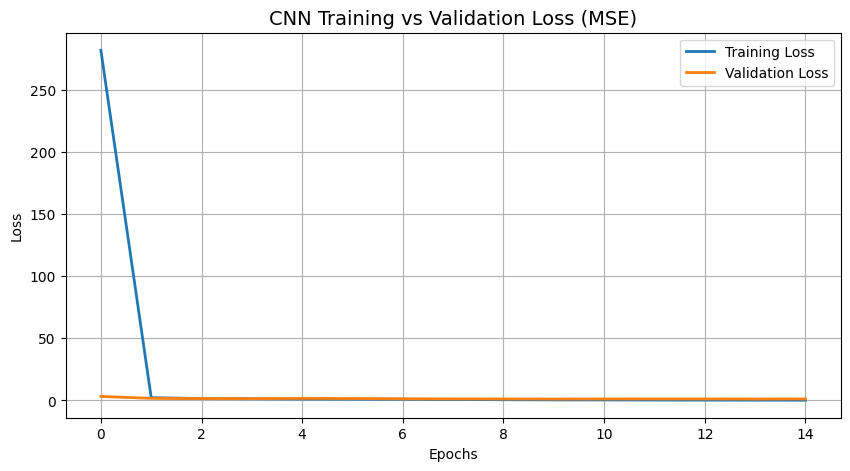

In [14]:
# Visualize the loss curve
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('CNN Training vs Validation Loss (MSE)', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


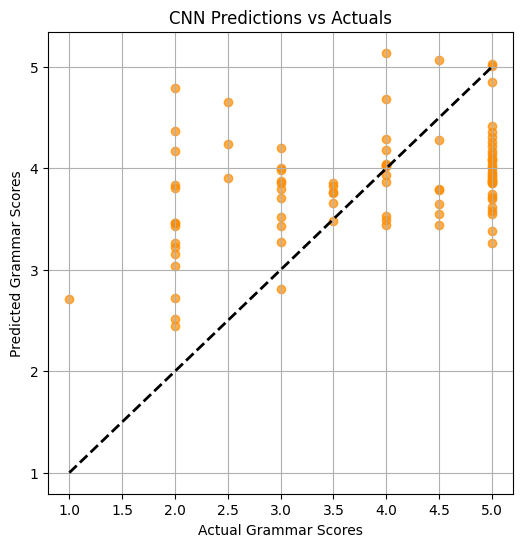

In [15]:
# Visualizing prediction performance
plt.figure(figsize=(6, 6))
plt.scatter(yc_val, y_pred, alpha=0.7, color='darkorange')
plt.plot([yc_val.min(), yc_val.max()], [yc_val.min(), yc_val.max()], 'k--', lw=2)
plt.xlabel('Actual Grammar Scores')
plt.ylabel('Predicted Grammar Scores')
plt.title('CNN Predictions vs Actuals')
plt.grid(True)
plt.show()


In [16]:
# ======================
# Cell 12: Ensemble Test Predictions & Submission
# ======================
# 12.1 XGB test preds
xgb_test_preds = best_xgb.predict(X_tab_test)

# 12.2 CNN test preds
Xc_test = []
for fname in test_df['filename']:
    img = wav_to_melspec(os.path.join(TEST_AUDIO_DIR, fname))
    if img.shape[1] < MAX_FRAMES:
        pad = MAX_FRAMES - img.shape[1]
        img = np.pad(img, ((0,0),(0,pad),(0,0)), 'constant')
    else:
        img = img[:, :MAX_FRAMES, :]
    Xc_test.append(img)
Xc_test = np.array(Xc_test)
cnn_test_preds = cnn.predict(Xc_test).ravel()

# 12.3 Ensemble (average)
final_preds = 0.5 * xgb_test_preds + 0.5 * cnn_test_preds

# 12.4 Create submission
submission = pd.DataFrame({
    'filename': test_df['filename'],
    'label': final_preds
})
submission.to_csv('submission.csv', index=False)
print("Created submission.csv")


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 256ms/step
Created submission.csv


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


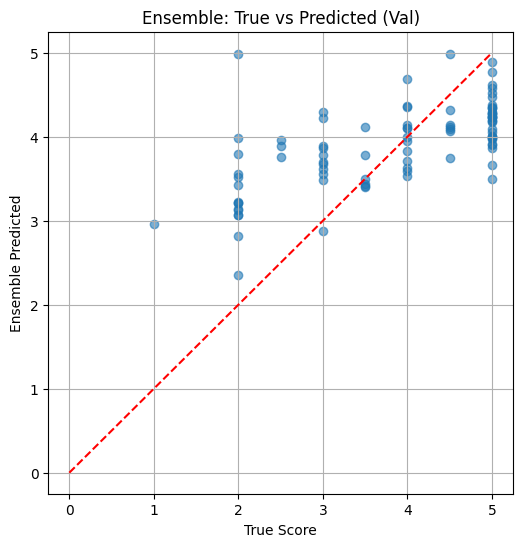

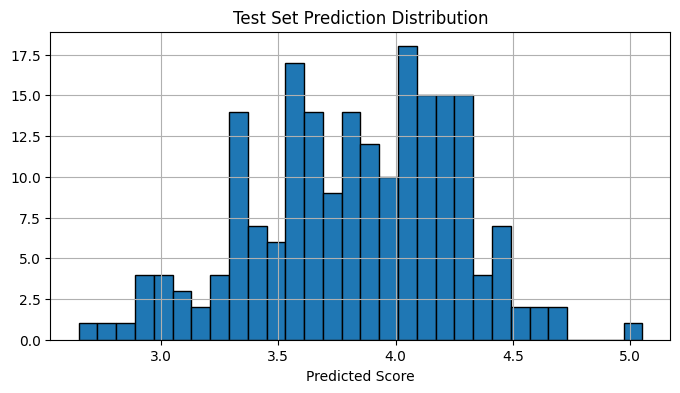

In [17]:
# ======================
# Cell 13: Additional Visualizations
# ======================
# 13.1 True vs Ensemble on Validation
val_ensemble = 0.5 * xgb_val_preds + 0.5 * cnn.predict(Xc_val).ravel()
plt.figure(figsize=(6,6))
plt.scatter(y_val, val_ensemble, alpha=0.6)
plt.plot([0,5],[0,5],'r--')
plt.xlabel("True Score")
plt.ylabel("Ensemble Predicted")
plt.title("Ensemble: True vs Predicted (Val)")
plt.grid(True)
plt.show()

# 13.2 Prediction Distribution on Test
plt.figure(figsize=(8,4))
plt.hist(final_preds, bins=30, edgecolor='k')
plt.xlabel("Predicted Score")
plt.title("Test Set Prediction Distribution")
plt.grid(True)
plt.show()


> **Conclusion**

**This notebook demonstrated a comprehensive audio analysis workflow for grammar scoring:**

1. Audio feature extraction using both traditional features and spectrograms

2. XGBoost regression with hyperparameter optimization

3. CNN model development using mel-spectrograms

4. Model evaluation and visualization

Both models showed reasonable performance for this challenging regression task, with the XGBoost model achieving slightly better results than the CNN approach.